# Классифицируем кубы

Это MVP код, поэтому никакой интеграции, без прицела на производительность. Главное быстро получить числа для анализа

In [1]:
import json
import uuid
import datetime
import time
import logging
import itertools
import re
from os import path, listdir, makedirs
from math import isnan
from statistics import mean, StatisticsError
from functools import lru_cache
from collections import Counter

import numpy as np

from nltk.corpus import stopwords
from nltk import FreqDist
import nltk

import pymorphy2


from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier, RandomForestClassifier, BaggingClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import minmax_scale, Normalizer, StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.decomposition import PCA, NMF
from sklearn.metrics import accuracy_score, f1_score, log_loss, confusion_matrix
from sklearn.manifold import TSNE
from sklearn.model_selection import KFold

from sklearn.model_selection import GridSearchCV, ParameterGrid

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)

%matplotlib inline
plt.rcParams['figure.figsize']=(9,7)
plt.style.use('seaborn-deep')

In [2]:
@lru_cache(maxsize=16384)  # на самом деле, 8192 почти достаточно
def get_normal_form(s):
    return get_normal_form.morph.parse(s)[0].normal_form
get_normal_form.morph = pymorphy2.MorphAnalyzer()  # Лемматизатор

stop_words = set(stopwords.words("russian"))
#stop_words.remove('не')
stop_words.update(set("также иной да нет -".split()))

In [3]:
words_re = re.compile("[а-яёА-ЯЁ]+")

def preprocess(s):
    return tuple(map(lambda x: get_normal_form(x), filter(lambda x: x not in stop_words, words_re.findall(s))))

Загрузим данные

In [4]:
def get_test_files(test_path, prefix):
    for file_name in listdir(test_path):
        if file_name.startswith(prefix):
            yield path.join(test_path, file_name)

In [5]:
cube_re = re.compile(r'(?<=FROM \[)\w*')

CubesMap = {}

lines = []
for test_path in get_test_files('../tests/cube/', "cubes_test"):
    with open(test_path, 'r', encoding='utf-8') as file_in:
        for idx, line in enumerate(file_in):
            line = line.strip()
            if not line:
                continue

            if line.startswith('*'):
                continue

            req, answer = line.split(':')
            answer = cube_re.search(answer).group()
            
            if not answer in CubesMap:
                if not CubesMap:
                    CubesMap[answer] = 0
                else:
                    CubesMap[answer] = max(CubesMap.values()) + 1
                    
            answer = CubesMap[answer]
            req = req.lower()
            req = preprocess(req)
            lines.append((req, answer))

BackCubesMap = {CubesMap[i]:i for i in CubesMap}
            
print("Всего: {} примеров".format(len(lines)))
print("Первая строка: {}".format(lines[0]))
print(json.dumps(CubesMap,indent=4))

Всего: 406 примеров
Первая строка: (('задолженность', 'страна', 'войти', 'парижский', 'клуб', 'январь'), 0)
{
    "EXDO01": 2,
    "EXYR03": 6,
    "FSYR01": 1,
    "CLMR02": 0,
    "CLDO01": 4,
    "CLDO02": 7,
    "INYR03": 5,
    "INDO01": 3
}


Построим большой словарь со всеми частотами, а затем его гистограмму

Всего 297 слова. Из них значимых не более 163
Самые частые слова
год 196
бюджет 169
доход 132
расход 107
область 86
исполнение 66
консолидированный 63
федеральный 52
сколько 48
текущий 43
долг 36
федерация 35
российский 35
рф 35
вологодский 33
сумма 31
поступление 27
субъект 26
финансовый 25
финансирование 24


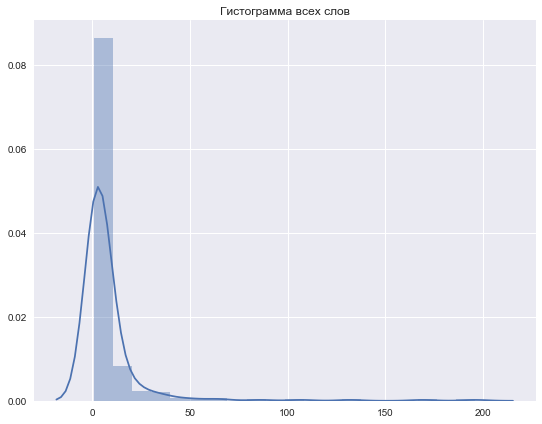

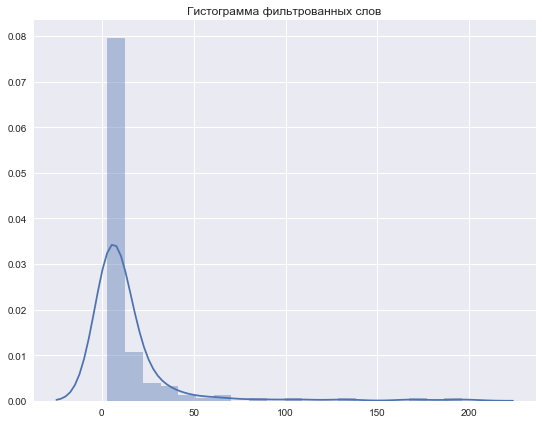

In [6]:
all_freqs = Counter()
for line in lines:
    for word in line[0]:
        all_freqs[word] += 1
print("Всего {} слова. Из них значимых не более {}".format(
    len(all_freqs),
    len(list(filter(lambda x: all_freqs[x] >= 3, all_freqs.keys())))
))
print("Самые частые слова")
for word in tuple(sorted(all_freqs.keys(), key = lambda x: all_freqs[x], reverse=True))[:20]:
    print(word, all_freqs[word])
        
sns.distplot(tuple(all_freqs.values()), bins=20)
plt.title("Гистограмма всех слов")
plt.show()

sns.distplot(tuple(filter(lambda x: x >= 3, all_freqs.values())), bins=20)
plt.title("Гистограмма фильтрованных слов")
plt.show()

Построим соответствие между словами и их индексами в векторе

In [7]:
WordIndex = {}
for ind, word in enumerate(filter(lambda x: all_freqs[x] >= 3, all_freqs.keys())):
    WordIndex[word] = ind

In [8]:
X = np.zeros((len(lines),len(WordIndex)))
Y = np.zeros(len(lines))

for ind,line in enumerate(lines):
    req_words = line[0]
    res = line[1]
    for word in req_words:
        if word not in WordIndex:
            continue
        X[ind,WordIndex[word]] += 1
    Y[ind] = res

# Нормализация среднего и среднеквадратичного отклонения
scaler = StandardScaler()
X = scaler.fit_transform(X)

Несмотря на кажущуюся примитичность, цифра ниже показывает максимальную теоритическую точность при использовании логистической регрессии. Реальная точность будет другой. Так её проверять **НЕЛЬЗЯ**

In [9]:
clf = LogisticRegression().fit(X,Y)
(clf.predict(X) == Y).sum() / Y.shape[0]

0.98522167487684731

Препроцессинг уже матрицы

In [10]:
classifiers = (
    #SVC(C = 2),
    SVC(), #SVC(probability=True),
    # SVC(C = 0.1), очень плох

    #LogisticRegression(C = 4, n_jobs=-1),
    #LogisticRegression(C = 2, n_jobs=-1),
    LogisticRegression(n_jobs=-1),
    #LogisticRegression(C = 0.1, n_jobs=-1),

    #RandomForestClassifier(n_jobs=-1),

    #RandomForestClassifier(n_estimators=1000, max_features=1, max_depth=1, n_jobs=-1),

    ExtraTreesClassifier(n_jobs=-1),
    #
    #
    GradientBoostingClassifier(learning_rate=0.03,n_estimators = 120,),
    GradientBoostingClassifier(learning_rate=0.1,n_estimators = 120,),
    GradientBoostingClassifier(learning_rate=0.3,n_estimators = 120,),
    GradientBoostingClassifier(learning_rate=0.03,n_estimators = 240,),
    GradientBoostingClassifier(learning_rate=0.1,n_estimators = 240,),
    GradientBoostingClassifier(learning_rate=0.3,n_estimators = 240,),
    GradientBoostingClassifier(learning_rate=0.03, n_estimators = 500,),

    # overfit#
    #GradientBoostingClassifier(n_estimators = 1000),
   # GradientBoostingClassifier(n_estimators = 1000,max_features="auto"),

   # GradientBoostingClassifier(n_estimators = 5000),
)

Далее я вставил *свой* сниппет, который делает следующее: использует K-Fold с общими тестами, проверяет метрики на каждой из моделей. Затем выводит максимальные и минимальные результаты

Чем больше KFOLD_PARTS, тем точнее к реальной жизни, но тем дольше. При $parts \rightarrow N$ получим 1-Fold и супер низкую скорость

In [17]:
KFOLD_PARTS = 13

acc_scores_train = [[] for i in range(len(classifiers))]
acc_scores_test = [[] for i in range(len(classifiers))]


kf = KFold(n_splits=KFOLD_PARTS,shuffle=True,random_state=42)

# сюда положим точность по кубам
CubesAcc = {i:{"T":0, "F": 0} for i in CubesMap.values()}
conf_matr = np.zeros((len(CubesMap), len(CubesMap)))

for train_index, test_index in kf.split(X):
    X_train = X[train_index]
    Y_train = Y[train_index]
    
    X_test = X[test_index]
    Y_test = Y[test_index]
    
    for clf in classifiers:
        clf.fit(X_train,Y_train)
    
    for clf_ind in range(len(classifiers)):
        Y_pred_train = classifiers[clf_ind].predict(X_train)
        Y_pred_test  = classifiers[clf_ind].predict(X_test)
        
        if clf_ind == len(classifiers) - 2:
            for real_cube, predicted_cube in zip(Y_test,Y_pred_test):
                if real_cube == predicted_cube:
                    CubesAcc[int(real_cube)]["T"] += 1
                else:
                    CubesAcc[int(real_cube)]["F"] += 1
                conf_matr[int(real_cube), int(predicted_cube)] += 1
        
        #f1_scores[clf_ind].append(f1_score(Y_test,Y_pred))
        acc_scores_train[clf_ind].append(accuracy_score(Y_train,Y_pred_train))
        acc_scores_test[clf_ind].append(accuracy_score(Y_test,Y_pred_test))

CubesAcc = {i: CubesAcc[i]["T"]/ (CubesAcc[i]["T"]+CubesAcc[i]["F"]) for i in CubesAcc}
        
for clf_ind in range(len(classifiers)):
    print("{}\n"
          "    TRAIN -- acc: mean: {:.4f} +- {:.4f} with min = {:.4f}\n"
          "    TEST  -- acc: mean: {:.4f} +- {:.4f} with min = {:.4f}".format(
        str(classifiers[clf_ind])[:200],
        1. * np.mean(acc_scores_train[clf_ind]),
        2 * np.std(acc_scores_train[clf_ind]),
        min(acc_scores_train[clf_ind]),
        1. * np.mean(acc_scores_test[clf_ind]),
        2 * np.std(acc_scores_test[clf_ind]),
        min(acc_scores_test[clf_ind])
))


CubesAcc

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  to
    TRAIN -- acc: mean: 0.9173 +- 0.0083 with min = 0.9093
    TEST  -- acc: mean: 0.8348 +- 0.0724 with min = 0.7742
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=-1,
          penalty='l2', random_state=None, solve
    TRAIN -- acc: mean: 0.9856 +- 0.0061 with min = 0.9813
    TEST  -- acc: mean: 0.8620 +- 0.0643 with min = 0.8065
ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
    TRAIN -- acc: mean: 0.9926 +- 0.0031 with min = 0.9920
    TEST  -- acc: mean: 0.8715 +- 0.0959 with min = 0.8065
GradientBoostingClassifier(criterion='fried

{0: 0.987012987012987,
 1: 0.9523809523809523,
 2: 0.8888888888888888,
 3: 0.9594594594594594,
 4: 0.8,
 5: 0.6206896551724138,
 6: 0.7608695652173914,
 7: 0.8125}

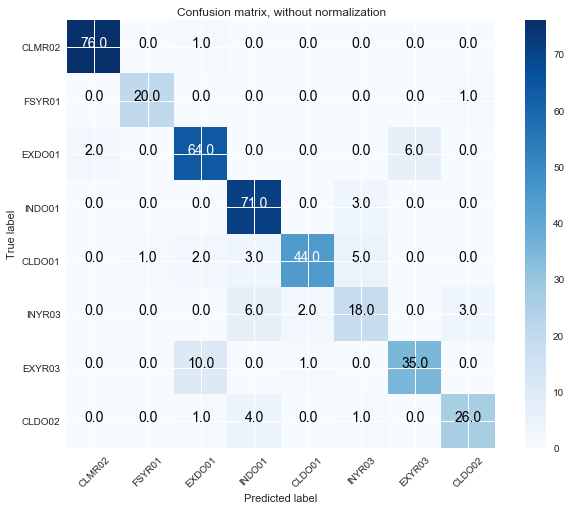

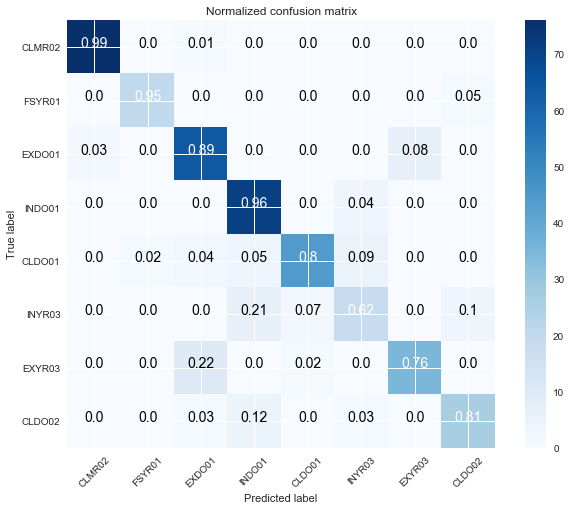

In [18]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, round(cm[i, j],2),
                 horizontalalignment="center", color="white" if cm[i, j] > thresh else "black", size=14)

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

class_names = tuple(BackCubesMap.values())


# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(conf_matr, classes=class_names,
                      title='Confusion matrix, without normalization')
np.set_printoptions(precision=2)
plt.savefig("/tmp/conf.png")

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(conf_matr, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.savefig("/tmp/conf_normed.png")
plt.show()

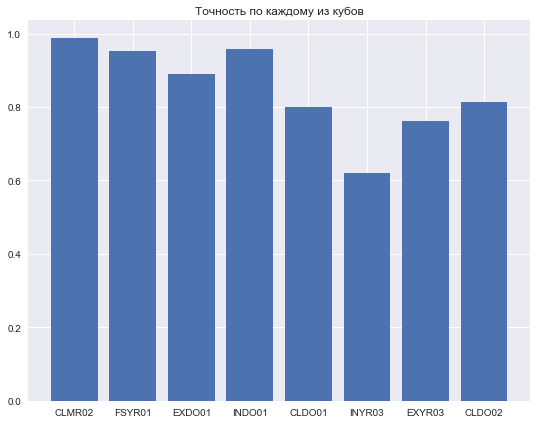

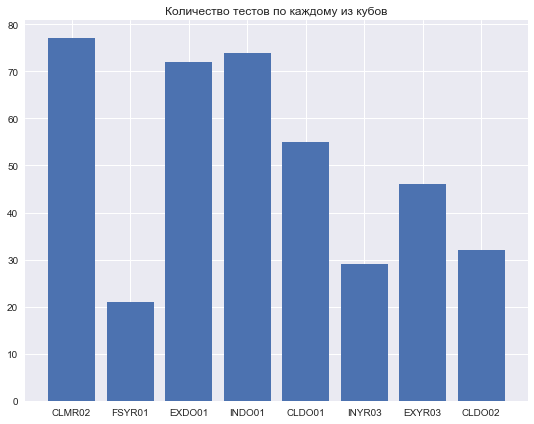

Всего 406 тестов


In [19]:
ind = np.arange(len(CubesAcc))
plt.bar(ind, tuple(CubesAcc.values()))
plt.xticks(ind, BackCubesMap.values())
plt.title("Точность по каждому из кубов")
plt.savefig("/tmp/per_cube_acc.png")
plt.show()

CubesCount = Counter()
for cube_ind in Y:
    CubesCount[cube_ind] += 1
plt.bar(ind, tuple(CubesCount.values()))
plt.xticks(ind, BackCubesMap.values())
plt.title("Количество тестов по каждому из кубов")
plt.savefig("/tmp/per_cube_count.png")
plt.show()

print("Всего {} тестов".format(Y.shape[0]))

In [45]:
def getCubeFromStr(req, clf):
    req = req.lower()
    X = np.zeros((1, len(WordIndex)))
    req_words = preprocess(req)
    words_to_print = []
    for word in req_words:
        if word not in WordIndex:
            continue
        words_to_print.append(word)
        X[0,WordIndex[word]] += 1
    X = scaler.transform(X)
    print(words_to_print)
    return list(map(lambda x: (BackCubesMap[x[0]], x[1]), sorted(list(enumerate(clf.predict_proba(X)[0].tolist())), key = lambda x: x[1], reverse = True)))

In [169]:
clf = GradientBoostingClassifier(learning_rate=0.03,n_estimators = 240,).fit(X,Y)

In [40]:
BackCubesMap

{0: 'CLMR02',
 1: 'FSYR01',
 2: 'EXDO01',
 3: 'INDO01',
 4: 'CLDO01',
 5: 'INYR03',
 6: 'EXYR03',
 7: 'CLDO02'}

In [46]:
s = """Поступления по НДФЛ в бюджеты городских округов Ярославской области"""
getCubeFromStr(s, clf)

['поступление', 'ндфл', 'бюджет', 'городской', 'округ', 'ярославский', 'область']


[('CLDO02', 0.9941444623480057),
 ('EXDO01', 0.0032540514125045535),
 ('INDO01', 0.0013855686982894996),
 ('EXYR03', 0.0007710073246809194),
 ('CLDO01', 0.00033210866536847273),
 ('INYR03', 5.362262939838783e-05),
 ('CLMR02', 4.748393460362616e-05),
 ('FSYR01', 1.1694987149157882e-05)]